<h1><center><span style='color:Balck'>DSC540-T301 Data Preparation (2233-1)</span></center></h1>
<h1><center><span style='color:Balck'>Term Project: Final Milestone No.5: Austin TX, Weather in Novemebr</span></center></h1>
<h1><center><span style='color:blue'>Arash Mahmooudian</span></center></h1>


<h1><left><span style='color:black'>Abstract</span></left></h1>

In this study we have captured weather information for the city of Austin, TX via three different data sources listed below:
 * Kaggle Austin weather analysis dataset in CSV format:
     link: https://www.kaggle.com/datasets/grubenm/austin-weather
 * Austin weather through from OpenWeatherMap API in JSON format:
     link: https://home.openweathermap.org/history_forecast_bulks/new
 * Austin weather from Wunderground for the month of Nov-2022 in HTML format:
     link: https://www.wunderground.com/history/monthly/us/tx/austin/KAUS/date/2022-11
     
## Goal:
Overall aim of this study is to be able to gether data from different data type sources and perform cleaning/transformation and finally store them in a database and perform post-processing with visualized exports.


## Steps Taken:

* 1- Download Kaggle dataset through the mentioned link.
* 2- Parse and then export/transform weather information through a web scraping process of the provided link above.
* 3- Hit the openweathermap API and export weather information a from json formatted data.
 
Finally having all these clean data we filter the weather info for the month of November and store them all in three different tables of SQLite data based, and provide visualized comparative graghs of them.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3

## Load already processed datasets
##### Perform final column name change/transformations

In [2]:
df_api = pd.read_csv('Austin_weather_api.csv')
df_kaggle = pd.read_csv('Austin_weather_kaggle_processed.csv')
df_website = pd.read_csv('Austin_weather_html.csv')

print('df_api: ',df_api.shape)
print('df_kaggle: ',df_kaggle.shape)
print('df_html: ',df_website.shape)

df_api:  (30, 24)
df_kaggle:  (1183, 21)
df_html:  (30, 17)


### Kaggle dataset clean ups/ trsansformations

df_kaggle is holding data for years 2013 to  July 2017, not Nov 2022. For this reason I will extract data for Nov 2014 
Which has less missing data (only one day Nov 3th) compared to other yesrs.

#### Kaggle:

In [3]:
# Split 'Data' to year, month and day

df_kaggle['year'] = [str(x).split('/')[2] for x in df_kaggle['Date']]
df_kaggle['day'] = [int(str(x).split('/')[1]) for x in df_kaggle['Date']]
df_kaggle['month'] = [str(x).split('/')[0] for x in df_kaggle['Date']]
#-------------------------------------------------------------------------


#df_kaggle_group = df_kaggle.groupby(['year', 'month'])['Date'].count()

df_kaggle = df_kaggle[(df_kaggle['year'] == '2014') & (df_kaggle['month'] == '11')]  # Filter data for Nov 2014
df_kaggle['Date'] = df_kaggle['day']                                                 # All datasets with come in this format
df_kaggle.drop(columns=['year','month','day'], inplace = True)                       # Drops unnecessary columns
#-------------------------------------------------------------------------

# Add an index of 'k_' to the begining of each attributes
# This because we want to distingush attributes for each datasets.
kaggle_columns = list(df_kaggle.columns)
for i in range(len(kaggle_columns)):    
    if (kaggle_columns[i] != 'Date'):
        kaggle_columns[i] = 'k_' + kaggle_columns[i]
      
        
kaggle_columns = list(df_kaggle.columns)
for i in range (len(kaggle_columns)):    
    kaggle_columns[i] = kaggle_columns[i].lower()
    
    if (kaggle_columns[i] != 'date'):
        kaggle_columns[i] = 'k_' + kaggle_columns[i]
    kaggle_columns[i] = kaggle_columns[i].replace('date','Date')
    kaggle_columns[i] = kaggle_columns[i].replace('f','')
    kaggle_columns[i] = kaggle_columns[i].replace('high','_max')
    kaggle_columns[i] = kaggle_columns[i].replace('low','_min')
    kaggle_columns[i] = kaggle_columns[i].replace('avg','_avg')
    kaggle_columns[i] = kaggle_columns[i].replace('percent','')
    kaggle_columns[i] = kaggle_columns[i].replace('sealevel','')
    kaggle_columns[i] = kaggle_columns[i].replace('inches','')
    kaggle_columns[i] = kaggle_columns[i].replace('miles','')
    kaggle_columns[i] = kaggle_columns[i].replace('mph','')
    kaggle_columns[i] = kaggle_columns[i].replace('mph','') 
    kaggle_columns[i] = kaggle_columns[i].replace('dewpoint','dew_point')

df_kaggle.columns = kaggle_columns
df_kaggle['Date'] = df_kaggle['Date'].astype(int)
df_kaggle.head()
        


,Date,k_temp_max,k_temp_avg,k_temp_min,k_dew_point_max,k_dew_point_avg,k_dew_point_min,k_humidity_max,k_humidity_avg,k_humidity_min,...,k_pressure_avg,k_pressure_min,k_visibility_max,k_visibility_avg,k_visibility_min,k_wind_max,k_wind_avg,k_windgust,k_precipitationsum,k_events
281,1,68,58,47,43,39,37,71,54,37,...,30.34,30.28,10,10,10,9,5,14,0.00,
282,2,75,62,48,52,45,39,80,61,41,...,30.26,30.18,10,10,10,15,6,25,0.00,
283,4,75,67,58,69,63,57,100,87,73,...,30.09,30.01,10,8,2,17,5,28,0.56,Rain
284,5,59,57,55,58,56,54,100,97,93,...,30.16,30.08,10,6,2,13,6,20,1.51,Rain
285,6,63,59,55,56,51,46,93,75,56,...,30.28,30.22,10,10,5,10,4,17,0.04,Rain


### OpenWeathermap called 'api' dataset for simplicity

In [4]:
# Apply some column name changes
# Add 'a_' index to beginning of each attributes, and common column as for other datasets

api_columns = list(df_api.columns)
for i in range (len(api_columns)):
    
    if (api_columns[i] != 'date'):
        api_columns[i] = 'a_' + api_columns[i]
        
    api_columns[i] = api_columns[i].lower()
    api_columns[i] = api_columns[i].replace('mean', 'avg')
    api_columns[i] = api_columns[i].replace('main_', '')
    api_columns[i] = api_columns[i].replace('.1', '')
    api_columns[i] = api_columns[i].replace('date', 'Date')
    
df_api.columns = api_columns 
#-------------------------------------------------------------------

# Split 'Data' to year, month and day
df_api['year'] = [str(x).split('-')[0] for x in df_api['Date']]
df_api['day'] = [int(str(x).split('-')[2]) for x in df_api['Date']]
df_api['month'] = [str(x).split('-')[1] for x in df_api['Date']]
df_api['Date'] = df_api['day']                                      # All datasets with come in this format

df_api.drop(columns=['year','month','day'], inplace = True)         # Drops unnecessary columns
#-------------------------------------------------------------------

# Metric conversion pressure to PSI and Visibility to Miles
for index, row in df_api.iterrows():
    pressure = row['a_pressure_min']
    psi = (pressure * 0.0145) *  2.03602
    df_api.loc[index, ['a_pressure_min']] = psi
    
    pressure = row['a_pressure_avg']
    psi = (pressure * 0.0145) *  2.03602
    df_api.loc[index, ['a_pressure_avg']] = psi
    
    pressure = row['a_pressure_max']
    psi = (pressure * 0.0145) *  2.03602
    df_api.loc[index, ['a_pressure_max']] = psi
    
    
    visibility = row['a_visibility_avg']
    df_api.loc[index, ['a_visibility_avg']] = visibility/1609

df_api.head()

,Date,a_visibility_avg,a_snow_avg,a_wind_speed_min,a_wind_speed_avg,a_wind_speed_max,a_wind_deg_min,a_wind_deg_avg,a_wind_deg_max,a_temp_min,...,a_feels_like_max,a_pressure_min,a_pressure_avg,a_pressure_max,a_humidity_min,a_humidity_avg,a_humidity_max,a_dew_point_min,a_dew_point_avg,a_dew_point_max
0,1,6.206132,0.0,0.00,4.679167,8.99,0,128.458333,360,55.42,...,70.63,29.935602,30.067222,30.171780,57,81.750000,96,54.59,58.840000,66.65
1,2,5.920447,0.0,0.00,3.819583,7.00,0,95.708333,221,58.28,...,77.86,30.053691,30.147178,30.230825,67,84.958333,94,57.25,60.628750,65.48
2,3,5.837088,0.0,3.44,10.071667,19.57,0,156.250000,190,68.58,...,86.25,29.876557,30.013098,30.083214,60,82.791667,94,64.99,68.006250,70.21
3,4,6.063290,0.0,8.05,15.317500,21.85,144,168.083333,190,71.67,...,91.17,29.610857,29.805212,29.906080,65,83.458333,93,67.62,71.251667,74.48
4,5,6.122773,0.0,0.00,5.559167,12.66,0,171.291667,357,50.02,...,79.52,29.728946,29.853186,29.965124,39,58.125000,92,37.54,48.070833,69.51


### Website driven data

In [5]:
# Apply some column name changes
# Add 'w_' index to beginning of each attributes, and common column as for other datasets

df_website_columns = list(df_website.columns)

for i in range (len(df_website_columns)):
    
    if (df_website_columns[i] != 'Time'):
        df_website_columns[i] = 'w_' + df_website_columns[i]
    
    df_website_columns[i] = df_website_columns[i].lower()
    df_website_columns[i] = df_website_columns[i].replace(' (°f)','')
    df_website_columns[i] = df_website_columns[i].replace(' (%)','')
    df_website_columns[i] = df_website_columns[i].replace(' (mph)','')
    df_website_columns[i] = df_website_columns[i].replace(' (in)','')
    df_website_columns[i] = df_website_columns[i].replace(' ','_')
    df_website_columns[i] = df_website_columns[i].replace('temperature','temp')
    df_website_columns[i] = df_website_columns[i].replace('time','Date')
    
df_website.columns = df_website_columns
#-------------------------------------------------------------------

# Split 'Data' to year, month and day

df_website['month'] = [str(x).split('/')[1]  for x in df_website['Date']]
df_website['day'] = [int(str(x).split('/')[2])   for x in df_website['Date']]
df_website['Date'] = df_website['day']                                          # All datasets with come in this format
df_website.drop(columns=['month','day'], inplace = True)                        # Drops unnecessary columns
df_website.head()

,Date,w_temp_max,w_temp_avg,w_temp_min,w_dew_point_max,w_dew_point_avg,w_dew_point_min,w_humidity_max,w_humidity_avg,w_humidity_min,w_wind_speed_max,w_wind_speed_avg,w_wind_speed_min,w_pressure_max,w_pressure_avg,w_pressure_min,w_precipitation
0,2022,66,60.8,55,62,59.5,55,100,95.7,75,7,2.4,0,29.6,29.6,29.5,0.05
1,2022,76,63.6,54,68,60.4,54,100,90.3,64,8,3.6,0,29.7,29.6,29.5,0.01
2,2022,84,74.6,69,70,68.7,65,100,83.2,53,20,12.2,7,29.5,29.4,29.3,0.00
3,2022,85,73.5,59,75,69.0,52,97,86.5,63,22,12.8,3,29.4,29.3,29.1,0.00
4,2022,71,59.4,50,55,49.5,42,100,73.0,42,12,5.2,0,29.4,29.3,29.3,0.41


#### CREATING DATABASE

In [6]:
with sqlite3.connect('austin_weather.db') as conn:
    cursor = conn.cursor()
    cursor.execute("""CREATE TABLE IF NOT EXISTS api (Date int, a_visibility_avg float, a_snow_avg float,
                                                    a_wind_speed_min float, a_wind_speed_avg float, a_wind_speed_max float,
                                                    a_wind_deg_min float, wind_deg_avg float, wind_deg_max float,
                                                    a_temp_min float, a_temp_avg float, a_temp_max float,
                                                    a_feels_like_min float, a_feels_like_avg float, a_feels_like_max float,
                                                    a_pressure_min float, a_pressure_avg float, a_pressure_max float,
                                                    a_humidity_min float, a_humidity_avg float, a_humidity_max float,
                                                    a_dew_point_min float, a_dew_point_avg float, a_dew_point_max float,
                                                    PRIMARY KEY (Date))""")    
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS kaggle (Date int, k_temp_max float, k_temp_avg float, k_temp_min float,                                                    
                                                    k_dew_point_max float, k_dew_point_avg float, k_dew_point_min float,
                                                    k_humidity_max float, k_humidity_avg float, k_humidity_min float,
                                                    k_pressure_max float, k_pressure_avg float, k_pressure_min float, 
                                                    k_visibility_max float, k_visibility_avg float, k_visibility_min float,
                                                    k_wind_max float, k_wind_avg float, k_windgust float, k_precipitationsum float,
                                                    k_events text,                                                    
                                                    PRIMARY KEY (Date))""")
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS website (Date int,
                                                w_temp_max float, w_temp_avg float, w_temp_min float,
                                                w_dew_point_max float, w_dew_point_avg float, w_dew_point_min float,
                                                w_humidity_max float, w_humidity_avg float, w_humidity_min float,
                                                w_wind_speed_max float, w_wind_speed_avg float, w_wind_speed_min float,
                                                w_pressure_max float, w_pressure_avg float, w_pressure_min float,
                                                w_precipitation float, 
                                                PRIMARY KEY (Date))""")
    
    #-------------------------------------------------------------------------------------
    
    # Import datasets into the created database tables
    
    df_api.to_sql('api',conn,if_exists='replace',index=False)
    df_kaggle.to_sql('kaggle',conn,if_exists='replace',index=False)
    df_website.to_sql('website',conn,if_exists='replace',index=False)
    
    conn.commit()


#### Read data from DataBase

In [7]:
with sqlite3.connect('austin_weather.db') as conn:
    cursor = conn.cursor()
    
    # Perform LEFT JOIN on all datasets based on the common key 'Date'
    df_combined = pd.read_sql_query("""SELECT *
                                        FROM
                                        (SELECT api.*, website.* FROM api LEFT JOIN website 
                                        ON api.Date = website.Date) t1 LEFT JOIN kaggle as t2
                                        ON t1.Date = t2.Date""", conn)
    
df_combined.head()

,Date,a_visibility_avg,a_snow_avg,a_wind_speed_min,a_wind_speed_avg,a_wind_speed_max,a_wind_deg_min,a_wind_deg_avg,a_wind_deg_max,a_temp_min,...,k_pressure_avg,k_pressure_min,k_visibility_max,k_visibility_avg,k_visibility_min,k_wind_max,k_wind_avg,k_windgust,k_precipitationsum,k_events
0,1,6.206132,0.0,0.00,4.679167,8.99,0,128.458333,360,55.42,...,30.34,30.28,10.0,10.0,10.0,9.0,5.0,14.0,0.00,
1,2,5.920447,0.0,0.00,3.819583,7.00,0,95.708333,221,58.28,...,30.26,30.18,10.0,10.0,10.0,15.0,6.0,25.0,0.00,
2,3,5.837088,0.0,3.44,10.071667,19.57,0,156.250000,190,68.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,4,6.063290,0.0,8.05,15.317500,21.85,144,168.083333,190,71.67,...,30.09,30.01,10.0,8.0,2.0,17.0,5.0,28.0,0.56,Rain
4,5,6.122773,0.0,0.00,5.559167,12.66,0,171.291667,357,50.02,...,30.16,30.08,10.0,6.0,2.0,13.0,6.0,20.0,1.51,Rain




<h1><left><span style='color:Black'>Visualizations</span></left></h1>



Comparative line graphs for the merged dataset having data from all three datasets

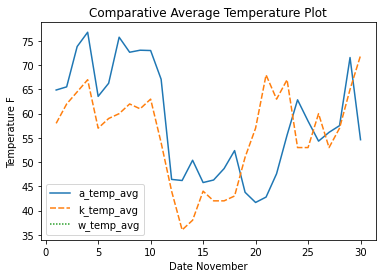

In [8]:
# Plot the average tempreture all datasets against each other
# w_temp_avg,  a_temp_avg, k_temp_avg
# 'w' stands for data pulled from website
# 'a' stands for data pulled via api
# 'k' stands for data pulled from kaggle dataset


df_temp = df_combined[['Date','w_temp_avg', 'a_temp_avg', 'k_temp_avg']]
df_temp = df_temp.T.groupby(level=0).first().T
df_temp.set_index('Date', inplace= True)

ax = sns.lineplot(data=df_temp)
ax.set(xlabel='Date November', ylabel='Temperature F', title='Comparative Average Temperature Plot')
ax.legend(loc='lower left')


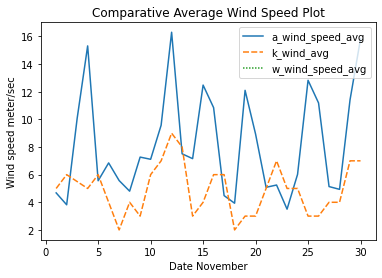

In [9]:
df_wind = df_combined[['Date','w_wind_speed_avg', 'a_wind_speed_avg', 'k_wind_avg']]
df_wind = df_wind.T.groupby(level=0).first().T
df_wind.set_index('Date', inplace= True)
ax = sns.lineplot(data=df_wind)
ax.set(xlabel='Date November', ylabel='Wind speed meter/sec', title='Comparative Average Wind Speed Plot')
ax.legend(loc='upper right')

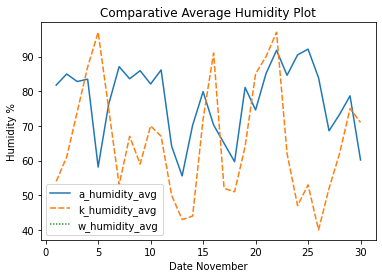

In [10]:
df_humidity = df_combined[['Date','w_humidity_avg', 'a_humidity_avg', 'k_humidity_avg']]
df_humidity = df_humidity.T.groupby(level=0).first().T
df_humidity.set_index('Date', inplace= True)
ax = sns.lineplot(data=df_humidity)
ax.set(xlabel='Date November', ylabel='Humidity %', title='Comparative Average Humidity Plot')
ax.legend(loc='lower left')

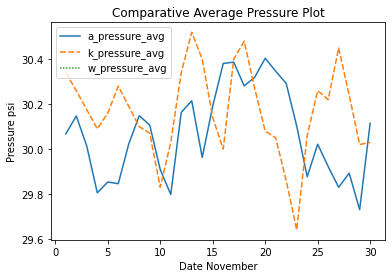

In [11]:
df_psi = df_combined[['Date','w_pressure_avg', 'a_pressure_avg', 'k_pressure_avg']]
df_psi = df_psi.T.groupby(level=0).first().T
df_psi.set_index('Date', inplace= True)

ax = sns.lineplot(data=df_psi)
ax.set(xlabel='Date November', ylabel='Pressure psi', title='Comparative Average Pressure Plot')
ax.legend(loc='upper left')

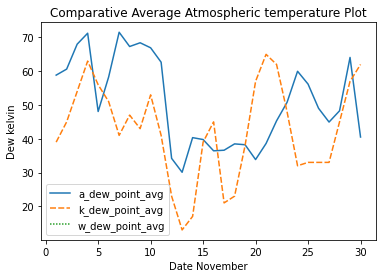

In [12]:
df_dew = df_combined[['Date','w_dew_point_avg', 'a_dew_point_avg', 'k_dew_point_avg']]
df_dew = df_dew.T.groupby(level=0).first().T
df_dew.set_index('Date', inplace= True)

ax = sns.lineplot(data=df_dew)

ax.set(xlabel='Date November', ylabel='Dew kelvin', title='Comparative Average Atmospheric temperature Plot')
ax.legend(loc='lower left')

<h1><left><span style='color:Black'>Comparative bar graphs for each data set</span></left></h1>


In [13]:
with sqlite3.connect('austin_weather.db') as conn:
    cursor = conn.cursor()
    
    # Perform LEFT JOIN on all datasets based on the common key 'Date'
    df_api_db = pd.read_sql_query("""SELECT * FROM api""", conn)
    df_website_db = pd.read_sql_query("""SELECT * FROM website""", conn)
    df_kaggle_db = pd.read_sql_query("""SELECT * FROM kaggle""", conn)

[Text(0.5, 0, 'November 2022'),
 Text(0, 0.5, 'Temperature F'),
 Text(0.5, 1.0, 'Comparative OpenWeather Temperature Plot')]

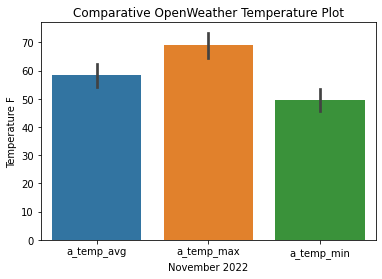

In [14]:
df_temp = df_api_db[['Date','a_temp_min', 'a_temp_avg', 'a_temp_max']]
df_temp = df_temp.T.groupby(level=0).first().T
df_temp.set_index('Date', inplace= True)

ax = sns.barplot(data=df_temp)
ax.set(xlabel='November 2022', ylabel='Temperature F', title='Comparative OpenWeather Temperature Plot')


[Text(0.5, 0, 'November 2022'),
 Text(0, 0.5, 'Temperature F'),
 Text(0.5, 1.0, 'Comparative Website Temperature Plot')]

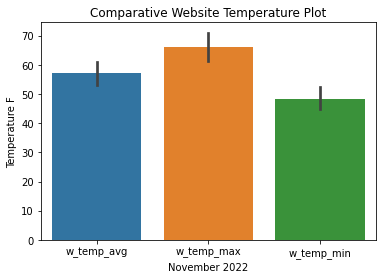

In [15]:
df_temp = df_website_db[['Date','w_temp_min', 'w_temp_avg', 'w_temp_max']]
df_temp = df_temp.T.groupby(level=0).first().T
df_temp.set_index('Date', inplace= True)

ax = sns.barplot(data=df_temp)
ax.set(xlabel='November 2022', ylabel='Temperature F', title='Comparative Website Temperature Plot')

[Text(0.5, 0, 'November 2014'),
 Text(0, 0.5, 'Temperature F'),
 Text(0.5, 1.0, 'Comparative Kaggle Temperature Plot')]

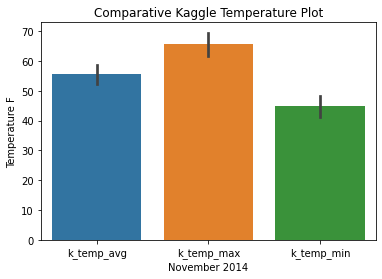

In [16]:
df_temp = df_kaggle_db[['Date','k_temp_min', 'k_temp_avg', 'k_temp_max']]
df_temp = df_temp.T.groupby(level=0).first().T
df_temp.set_index('Date', inplace= True)

ax = sns.barplot(data=df_temp)
ax.set(xlabel='November 2014', ylabel='Temperature F', title='Comparative Kaggle Temperature Plot')

## Datasets

In [17]:
df_api_db

,Date,a_visibility_avg,a_snow_avg,a_wind_speed_min,a_wind_speed_avg,a_wind_speed_max,a_wind_deg_min,a_wind_deg_avg,a_wind_deg_max,a_temp_min,...,a_feels_like_max,a_pressure_min,a_pressure_avg,a_pressure_max,a_humidity_min,a_humidity_avg,a_humidity_max,a_dew_point_min,a_dew_point_avg,a_dew_point_max
0,1,6.206132,0.0,0.00,4.679167,8.99,0,128.458333,360,55.42,...,70.63,29.935602,30.067222,30.171780,57,81.750000,96,54.59,58.840000,66.65
1,2,5.920447,0.0,0.00,3.819583,7.00,0,95.708333,221,58.28,...,77.86,30.053691,30.147178,30.230825,67,84.958333,94,57.25,60.628750,65.48
2,3,5.837088,0.0,3.44,10.071667,19.57,0,156.250000,190,68.58,...,86.25,29.876557,30.013098,30.083214,60,82.791667,94,64.99,68.006250,70.21
3,4,6.063290,0.0,8.05,15.317500,21.85,144,168.083333,190,71.67,...,91.17,29.610857,29.805212,29.906080,65,83.458333,93,67.62,71.251667,74.48
4,5,6.122773,0.0,0.00,5.559167,12.66,0,171.291667,357,50.02,...,79.52,29.728946,29.853186,29.965124,39,58.125000,92,37.54,48.070833,69.51
5,6,6.215040,0.0,0.00,6.849583,19.57,0,164.250000,230,48.22,...,87.78,29.787991,29.845805,29.906080,55,76.208333,91,50.05,58.298750,71.51
6,7,6.096048,0.0,0.00,5.571667,11.50,0,119.083333,200,69.03,...,88.02,29.847035,30.022939,30.142258,70,87.083333,96,67.73,71.543750,74.91
7,8,5.956080,0.0,0.00,4.803750,10.00,0,92.916667,180,62.58,...,79.68,30.053691,30.148409,30.230825,71,83.583333,93,61.32,67.317500,70.77
8,9,6.215040,0.0,3.44,7.270417,16.11,0,112.875000,180,66.45,...,84.02,29.994647,30.106585,30.171780,66,85.916667,94,65.68,68.426667,70.25
9,10,6.104982,0.0,3.44,7.111250,12.66,0,123.750000,200,66.22,...,83.17,29.758468,29.908540,29.994647,63,82.083333,93,65.16,66.936250,69.82


In [18]:
df_website_db

,Date,w_temp_max,w_temp_avg,w_temp_min,w_dew_point_max,w_dew_point_avg,w_dew_point_min,w_humidity_max,w_humidity_avg,w_humidity_min,w_wind_speed_max,w_wind_speed_avg,w_wind_speed_min,w_pressure_max,w_pressure_avg,w_pressure_min,w_precipitation
0,2022,66,60.8,55,62,59.5,55,100,95.7,75,7,2.4,0,29.6,29.6,29.5,0.05
1,2022,76,63.6,54,68,60.4,54,100,90.3,64,8,3.6,0,29.7,29.6,29.5,0.01
2,2022,84,74.6,69,70,68.7,65,100,83.2,53,20,12.2,7,29.5,29.4,29.3,0.00
3,2022,85,73.5,59,75,69.0,52,97,86.5,63,22,12.8,3,29.4,29.3,29.1,0.00
4,2022,71,59.4,50,55,49.5,42,100,73.0,42,12,5.2,0,29.4,29.3,29.3,0.41
5,2022,83,66.5,48,73,62.2,47,100,86.9,63,20,5.2,0,29.4,29.4,29.3,0.00
6,2022,84,74.9,68,75,71.3,67,100,89.4,58,12,4.9,0,29.6,29.5,29.5,0.00
7,2022,78,69.1,60,71,66.6,60,100,92.3,76,10,3.2,0,29.7,29.6,29.6,0.11
8,2022,81,71.2,64,69,67.0,64,100,87.6,58,16,6.2,0,29.6,29.5,29.4,0.02
9,2022,81,71.5,64,69,66.4,63,100,85.5,54,15,7.1,3,29.4,29.3,29.2,0.00


In [19]:
print(df_kaggle_db)

    Date  k_temp_max  k_temp_avg  k_temp_min  k_dew_point_max  \
0      1          68          58          47               43   
1      2          75          62          48               52   
2      4          75          67          58               69   
3      5          59          57          55               58   
4      6          63          59          55               56   
5      7          71          60          48               49   
6      8          75          62          48               52   
7      9          74          61          47               45   
8     10          76          63          49               61   
9     11          65          54          42               62   
10    12          51          44          36               29   
11    13          41          36          31               17   
12    14          45          38          30               23   
13    15          48          44          40               47   
14    16          50     

In [20]:
print(df_combined)

    Date  a_visibility_avg  a_snow_avg  a_wind_speed_min  a_wind_speed_avg  \
0      1          6.206132         0.0              0.00          4.679167   
1      2          5.920447         0.0              0.00          3.819583   
2      3          5.837088         0.0              3.44         10.071667   
3      4          6.063290         0.0              8.05         15.317500   
4      5          6.122773         0.0              0.00          5.559167   
5      6          6.215040         0.0              0.00          6.849583   
6      7          6.096048         0.0              0.00          5.571667   
7      8          5.956080         0.0              0.00          4.803750   
8      9          6.215040         0.0              3.44          7.270417   
9     10          6.104982         0.0              3.44          7.111250   
10    11          6.215040         0.0              1.99          9.574583   
11    12          6.215040         0.0             11.50        

<h1><left><span style='color:Black'>Austin Weather Analysis</span></left></h1>

### Introduction
In this study, we have used three different weather datasets for Austin weather analysis. These datasets were gathered from three different sources and formats (CSV, JSON, and HTML table).

#### Data Description:

First: Kaggle Austin weather analysis dataset in CSV format: This dataset is in CSV format and contains data for every date from 2013-12-21 to 2017-07-31. It has 1319 rows and 21 columns. For our analysis, we only used the Month of November in 2014 because it had fewer missing values as compared to other years. The following are attributes found in this dataset: link: https://www.kaggle.com/datasets/grubenm/austin-weather

Second: Austin weather captured from OpenWeatherMap in JSON format. It contains data from 2013-12-01 to 2022-12-08 with 82540 rows and 26 columns. link: https://home.openweathermap.org/history_forecast_bulks/new

Third: Austin weather from the Wunderground website for the month of Nov-2022 in HTML format. It consists of 19 different variables. For our analysis, we have used daily resolution for the month of November 2022. Totally it consists of 19 different attributes with 30 rows. For this purpose, we have used the BeautifulSoup library to be able to perform web scraping and convert the HTML format table into a pandas data frame. link: https://www.wunderground.com/history/monthly/us/tx/austin/KAUS/date/2022-11

### Relationships
These datasets are connected to each other using the city name (Austin) and date (Month Nov). It is also worth mentioning that the JSON format file has been downloaded from OpenWeatherMap through the bulk history feature. There was no specific API to get these historical data through an API, however, we have an open API to get real-time/historical weather information from this website.

### Data Clean-up
After data cleaning (handling missing data/transformation/header name change) of these datasets the final products were stored in an SQLite database for further analysis (Joining through a common key of date). In the end, we pulled these data out from the SQLite database and used a python visualization library called "Seaborn: graphical representation of weather information have plotted to provide visual insights.

### Lessen learned
Data from different sources might be coming in different formats and metrics, for this, we need to be equipped well with the coding tools (pandas, scipy, numpy, ...) in order to be able to handle them appropriately. Web scraping was a more challenging part of data wrangling as the HTML tables have no specific standard format. Finally, after saving these datasets in an SQLite database I observed that the volume of storage has been reduced as compared to having them all in CSV formats.

### Ethical Implications
In order to minimize the physical and emotional harm following steps have been taken:
 * Reference links are provided in case one might need to validate the results.
 * The transformation has been clearly outlined in each milestone and efforts spent to minimize the error rate and reflect reality.
 * Formulas for conversion have already been validated.
 
### Conclusion
Insights provided through the line and bar graphs show that there is a strong correlation between data coming from OpenWeatherMap and from the website as both are referring to the same year and month Nov 2022, however, the difference between them and Kaggle is because Kaggle data represents weather info for Nov 2014. This in turn shows that Nov 2014 was colder than Nov 2022 in this city. On the other hand, we see that metrics: Temperature, Wind speed, Humidity, and Atmospheric Temperature in 2014 Austin has a lower value compared to 2022, except for Pressure.

Finally, overall Data wrangling (Gathering, cleaning, transformation, saving,... ) is almost 90% of a data science task to prepare an accurate and reliable data source for the final analysis. The steps must be documented well so one can understand how data was gathered and transformed.